exp
####################################################################################################
    valid train mode
####################################################################################################


  0%|                                                                       | 0/236 [00:00<?, ?it/s]

Epoch[1/1]


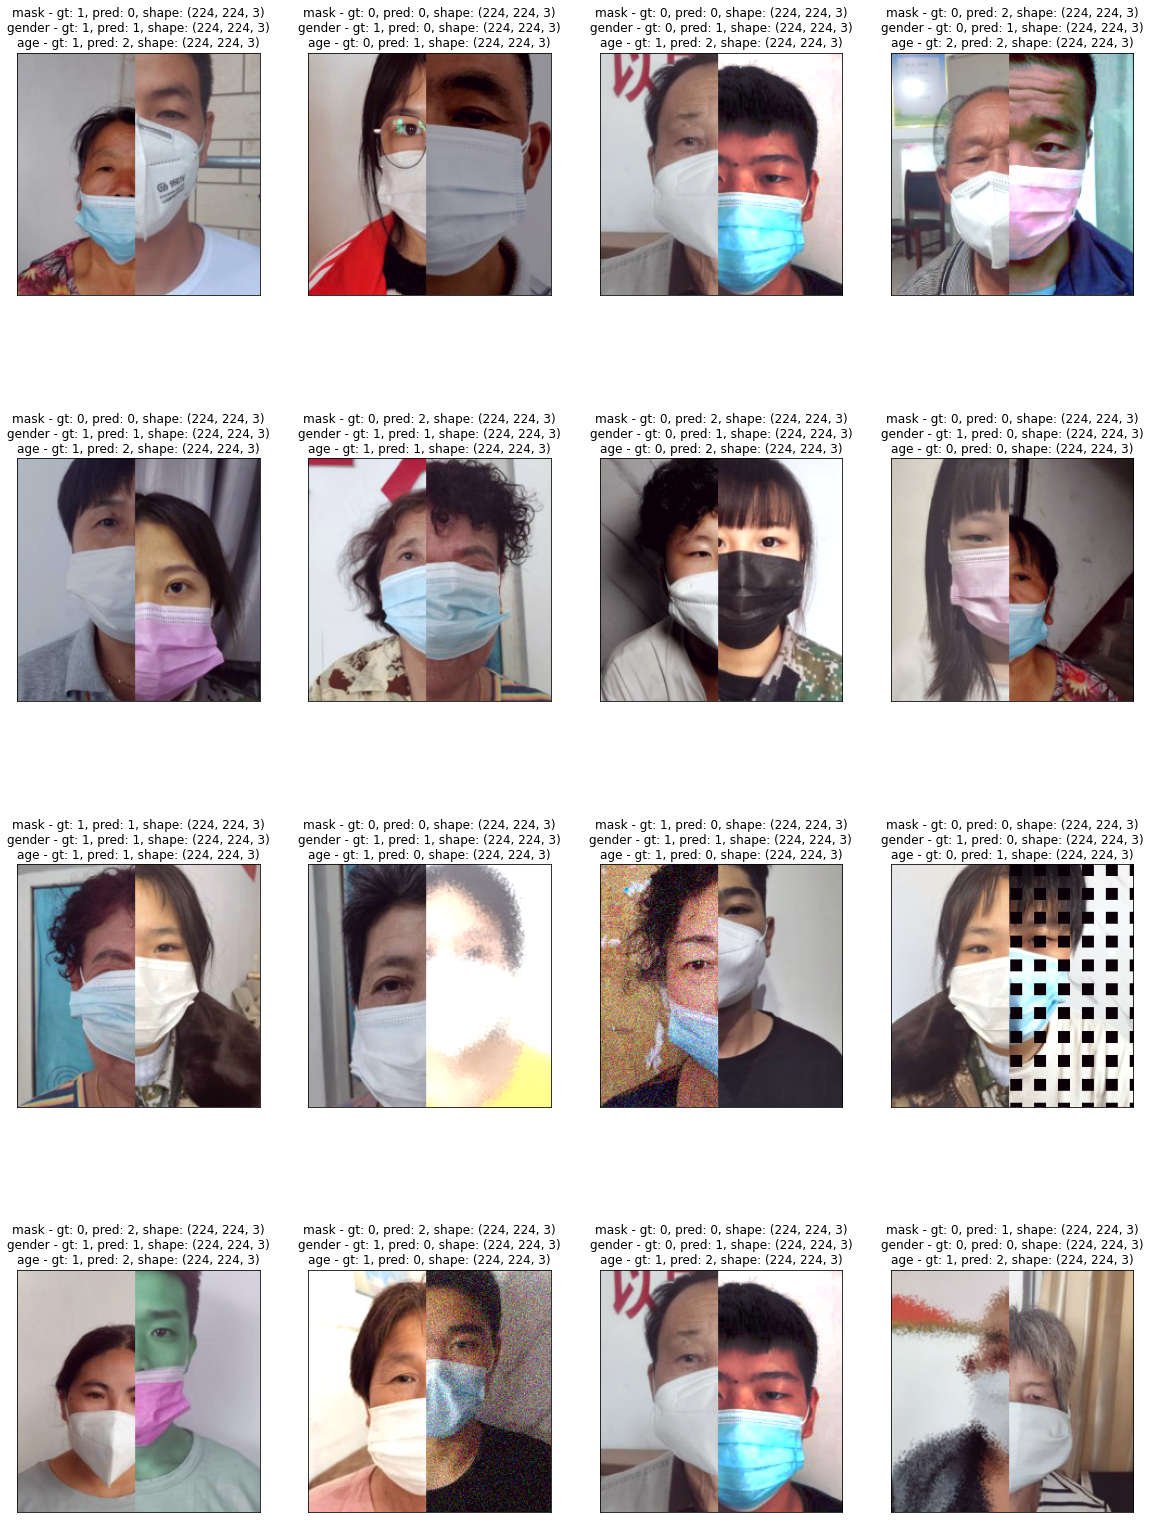

  1%|▊                                                              | 3/236 [00:05<09:55,  2.56s/it]

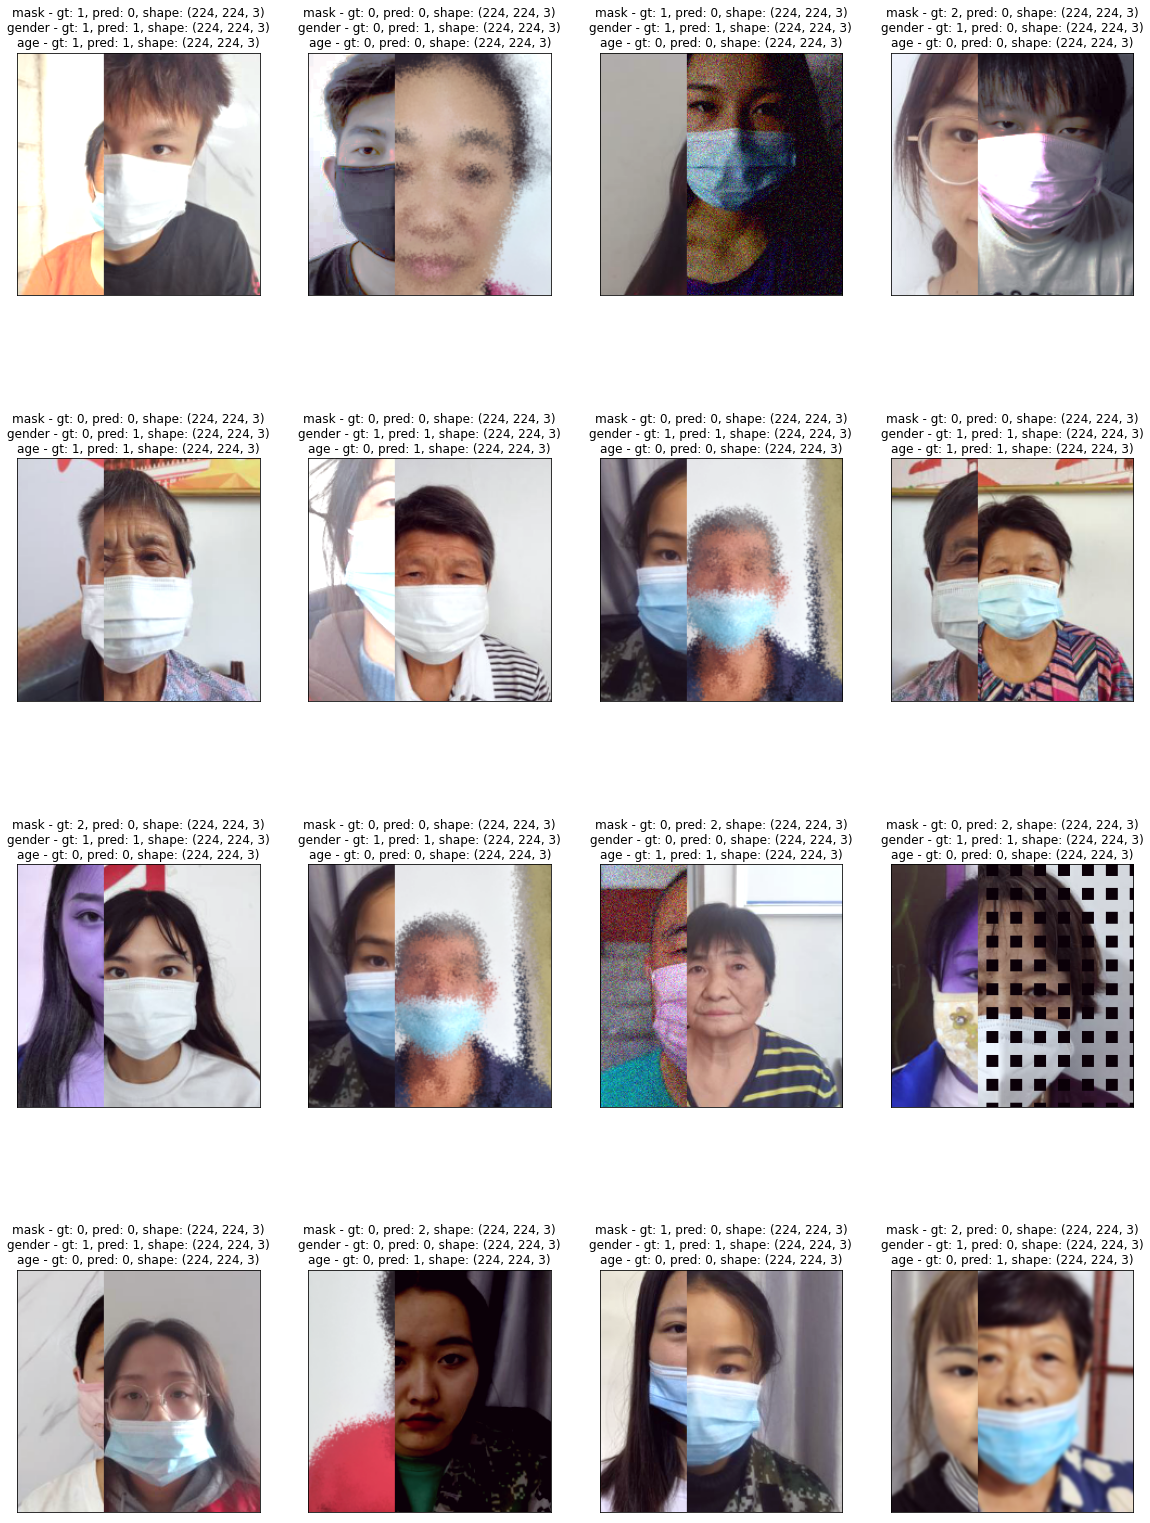

  2%|█                                                              | 4/236 [00:08<10:44,  2.78s/it]

In [1]:
import argparse
import glob
import json
# from module.wandb import init_wandb, log_wandb, login_wandb
import multiprocessing
import os
import random
import re
from importlib import import_module
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
# from torch.utils.tensorboard import SummaryWriter

from datasets.dataset import MaskBaseDataset
from module.loss import create_criterion
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
# %matplotlib inline


def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


# def grid_image(np_images, gts, preds, n=16, shuffle=False):
#     batch_size = np_images.shape[0]
#     assert n <= batch_size

#     choices = random.choices(range(batch_size), k=n) if shuffle else list(range(n))
#     figure = plt.figure(figsize=(20, 30 + 2))  # cautions: hardcoded, 이미지 크기에 따라 figsize 를 조정해야 할 수 있습니다. T.T
#     figure.set_facecolor('w')
#     plt.subplots_adjust(top=0.8)               # cautions: hardcoded, 이미지 크기에 따라 top 를 조정해야 할 수 있습니다. T.T
#     n_grid = np.ceil(n ** 0.5)
#     tasks = ["mask", "gender", "age"]
#     for idx, choice in enumerate(choices):
#         gt = gts[choice].item()
#         pred = preds[choice].item()
#         image = np_images[choice]
#         # title = f"gt: {gt}, pred: {pred}"
#         gt_decoded_labels = MaskBaseDataset.decode_multi_class(gt)
#         pred_decoded_labels = MaskBaseDataset.decode_multi_class(pred)
#         title = "\n".join([
#             f"{task} - gt: {gt_label}, pred: {pred_label}, shape: {image.shape}"
#             for gt_label, pred_label, task
#             in zip(gt_decoded_labels, pred_decoded_labels, tasks)
#         ])

#         plt.subplot(n_grid, n_grid, idx + 1, title=title)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         plt.imshow(image, cmap=plt.cm.binary)
#         plt.show()

#     return figure

def grid_image(np_images, gts, preds, n=16, shuffle=False) :
    batch_size = np_images.shape[0]
    assert n <= batch_size

    choices = random.choices(range(batch_size), k=n) if shuffle else list(range(n))
    figure = plt.figure(figsize=(20, 30 + 2))  # cautions: hardcoded, 이미지 크기에 따라 figsize 를 조정해야 할 수 있습니다. T.T
    figure.set_facecolor('w')
    plt.subplots_adjust(top=0.8)               # cautions: hardcoded, 이미지 크기에 따라 top 를 조정해야 할 수 있습니다. T.T
    n_grid = np.ceil(n ** 0.5)
    tasks = ["mask", "gender", "age"]

    for idx, choice in enumerate(choices):
        gt = gts[choice].item()
        pred = preds[choice].item()
        image = np_images[choice]
        # title = f"gt: {gt}, pred: {pred}"
        gt_decoded_labels = MaskBaseDataset.decode_multi_class(gt)
        pred_decoded_labels = MaskBaseDataset.decode_multi_class(pred)
        title = "\n".join([
            f"{task} - gt: {gt_label}, pred: {pred_label}, shape: {image.shape}"
            for gt_label, pred_label, task in zip(gt_decoded_labels, pred_decoded_labels, tasks)
        ])
        plt.subplot(n_grid, n_grid, idx + 1, title=title)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
    
    plt.show()
    return figure



def increment_path(path, exist_ok=False):
    """ Automatically increment path, i.e. runs/exp --> runs/exp0, runs/exp1 etc.

    Args:
        path (str or pathlib.Path): f"{args.save_dir}/{args.name}".
        exist_ok (bool): whether increment path (increment if False).
    """
    path = Path(path)
    if (path.exists() and exist_ok) or (not path.exists()):
        return str(path)
    else:
        dirs = glob.glob(f"{path}*")
        matches = [re.search(rf"%s(\d+)" % path.stem, d) for d in dirs]
        i = [int(m.groups()[0]) for m in matches if m]
        n = max(i) + 1 if i else 2
        return f"{path}{n}"


def rand_bbox(size, lam): # size : [Batch_size, Channel, Width, Height]
    W = size[2] 
    H = size[3] 
    cut_rat = np.sqrt(1. - lam)  # 패치 크기 비율
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)  

   	# 패치의 중앙 좌표 값 cx, cy
    cx = np.random.randint(W)
    cy = np.random.randint(H)
		
    # 패치 모서리 좌표 값 
    bbx1 = 0
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = W
    bby2 = np.clip(cy + cut_h // 2, 0, H)
   
    return bbx1, bby1, bbx2, bby2


def train(args, train_dataset, valid_dataset, train_transform, valid_transform):
    # -- data_loader
    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        num_workers=multiprocessing.cpu_count()//2,
        shuffle=True,
        pin_memory=use_cuda,
        drop_last=True,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=args.valid_batch_size,
        num_workers=multiprocessing.cpu_count()//2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=True,
    )

    device = torch.device("cuda" if use_cuda else "cpu")

    # -- model
    model_module = getattr(import_module("models."+args.usermodel), args.model)  # default: rexnet_200base
    model = model_module(
        num_classes=args.num_classes
    ).to(device)
    # model = torch.nn.DataParallel(model)

    # -- loss & metric
    criterion = create_criterion(args.criterion)  # default: cross_entropy
    opt_module = getattr(import_module("torch.optim"), args.optimizer)  # default: Adam
    optimizer = opt_module(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=args.lr,
        weight_decay=5e-4
    )
    scheduler = StepLR(optimizer, args.lr_decay_step, gamma=0.5)

    best_val_acc = 0
    best_val_loss = np.inf
    best_val_f1 = 0
    
    stop_cnt = 0
    for epoch in range(args.epochs):
        # train loop
        model.train()
        if isinstance(train_dataset, Subset):
            train_dataset.dataset.set_transform(train_transform)

        loss_value = 0
        matches = 0
        f1_sum = 0
        print(f"Epoch[{epoch+1}/{args.epochs}]")
        for idx, train_batch in enumerate(pbar := tqdm(train_loader, ncols=100)):
            inputs, labels = train_batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            ###
            BETA = 1
            if BETA > 0 and np.random.random()>0.5: # cutmix가 실행될 경우     
                lam = np.random.beta(BETA, BETA)
                rand_index = torch.randperm(inputs.size()[0]).to(device)
                target_a = labels # 원본 이미지 label
                target_b = labels[rand_index] # 패치 이미지 label       
                bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
                inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
                outs = model(inputs)
                loss = criterion(outs, target_a) * lam + criterion(outs, target_b) * (1. - lam) # 패치 이미지와 원본 이미지의 비율에 맞게 loss를 계산을 해주는 부분

                inputs_np = torch.clone(inputs).detach().cpu().permute(0, 2, 3, 1).numpy()
                inputs_np = MaskBaseDataset.denormalize_image(inputs_np, train_transform.mean, train_transform.std)
                figure = grid_image(
                    inputs_np, labels, torch.argmax(outs, dim=1), n=16, shuffle=True
                )

            else: # cutmix가 실행되지 않았을 경우
                outs = model(inputs) 
                loss= criterion(outs, labels)
            ###

            preds = torch.argmax(outs, dim=-1)

            loss.backward()
            optimizer.step()

            loss_value += loss.item()
            matches += (preds == labels).sum().item()
            f1_sum += f1_score(labels.data.cpu().numpy(), preds.cpu().numpy(), average='macro')
            if ((idx + 1) % args.log_interval == 0) or ((idx + 1) == len(train_loader)):
                train_loss = loss_value / (idx+1)
                train_acc = matches / args.batch_size / (idx+1)
                train_f1 = f1_sum / (idx+1)
                current_lr = get_lr(optimizer)
                pbar.set_description(f"loss_{train_loss:4.4}, f1_{train_f1:4.4}, acc_{train_acc:4.2%}, lr_{current_lr}")
                # print(
                #     f"Epoch[{epoch}/{args.epochs}]({idx + 1}/{len(train_loader)}) || "
                #     f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
                # )
                # logger.add_scalar("Train/loss", train_loss, epoch * len(train_loader) + idx)
                # logger.add_scalar("Train/accuracy", train_acc, epoch * len(train_loader) + idx)
                
                # loss_value = 0
                # matches = 0
        # else:
            # log_wandb('train',train_acc, train_f1, train_loss, False)
        scheduler.step()
        
        # val loop
        with torch.no_grad():
            print("Calculating validation results...")
            model.eval()
            if isinstance(valid_dataset, Subset):
                valid_dataset.dataset.set_transform(valid_transform)

            val_loss_items = []
            val_acc_items = []
            val_f1_items = []
            # figure = None
            for val_batch in tqdm(valid_loader, ncols=100):
                inputs, labels = val_batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outs = model(inputs)
                preds = torch.argmax(outs, dim=-1)

                loss_item = criterion(outs, labels).item()
                acc_item = (labels == preds).sum().item()
                f1 = f1_score(labels.data.cpu().numpy(), preds.cpu().numpy(), average='macro')
                val_loss_items.append(loss_item)
                val_acc_items.append(acc_item)
                val_f1_items.append(f1)
                

                # 한번씩 여기서 미친듯이 렉먹는듯
                # if figure is None:
                #     inputs_np = torch.clone(inputs).detach().cpu().permute(0, 2, 3, 1).numpy()
                #     inputs_np = MaskBaseDataset.denormalize_image(inputs_np, valid_transform.mean, valid_transform.std)
                #     figure = grid_image(
                #         inputs_np, labels, preds, n=16, shuffle=args.validdataset != "MaskSplitByProfileDataset"
                #     )

            val_loss = np.sum(val_loss_items) / len(valid_loader)
            val_acc = np.sum(val_acc_items) / len(valid_dataset)
            val_f1 = np.sum(val_f1_items) / len(valid_loader)
            # log_wandb('valid', val_acc, val_f1, val_loss, False)

            if val_acc > best_val_acc:
                # print(f"New best model for val accuracy : {val_acc:4.2%}! saving the best model..")
                # torch.save(model.state_dict(), f"{args.save_dir}/[{args.fold_idx}]_best.pth")
                # stop_cnt = 0
                best_val_acc = val_acc
                
            if val_loss < best_val_loss:
                # print(f"New best model for val loss : {val_loss:.4}! saving the best model..")
                # torch.save(model.state_dict(), f"{args.save_dir}/[{args.fold_idx}]_best.pth")
                # stop_cnt = 0
                best_val_loss = val_loss
                
            if val_f1 > best_val_f1:
                print(f"New best model for val F1 : {val_f1:.4}! saving the best model..")
                torch.save(model.state_dict(), f"{args.save_dir}/[{args.fold_idx}]_best.pth")
                stop_cnt = 0
                best_val_f1 = val_f1

                
            torch.save(model.state_dict(), f"{args.save_dir}/[{args.fold_idx}]_last.pth")
            print(
                f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2}, f1: {val_f1:4.2} || "
                f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2} best F1: {best_val_f1:4.2}"
            )
            # logger.add_scalar("Val/loss", val_loss, epoch)
            # logger.add_scalar("Val/accuracy", val_acc, epoch)
            # logger.add_figure("results", figure, epoch)
            print()

        if args.earlystop != 0 and args.earlystop <= stop_cnt:
            print(f'[earlystop: {stop_cnt}] No future. bye bye~~')
            break
        stop_cnt += 1
    # log_wandb('best', val_acc, best_val_f1, val_loss, False)
    



# if __name__ == '__main__':
parser = argparse.ArgumentParser()

from dotenv import load_dotenv
import os
load_dotenv(verbose=True)

# Data and model checkpoints directories
parser.add_argument('--name', default='exp', help='model save at {SM_SAVE_DIR}/{name}')
parser.add_argument('--epochs', type=int, default=1, help='number of epochs to train (default: 1)')
parser.add_argument('--model', type=str, default='rexnet_200base', help='model type (default: rexnet_200base)')
parser.add_argument('--traindataset', type=str, default='basicDatasetA', help='train dataset augmentation type (default: basicDatasetA)')
# parser.add_argument('--validdataset', type=str, default='basicDatasetA', help='validation dataset augmentation type (default: basicDatasetA)')
parser.add_argument('--trainaug', type=str, default='A_simple_trans', help='train data augmentation type (default: A_simple_trans)')
parser.add_argument('--validaug', type=str, default='A_centercrop_trans', help='validation data augmentation type (default: A_centercrop_trans)')
parser.add_argument("--resize", nargs="+", type=list, default=[224, 224], help='resize size for image when training')
parser.add_argument('--criterion', type=str, default='cross_entropy', help='criterion type (default: cross_entropy)')
parser.add_argument('--optimizer', type=str, default='Adam', help='optimizer type (default: Adam)')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate (default: 1e-3)')
parser.add_argument('--val_ratio', type=float, default=0.2, help='ratio for validaton (default: 0.1)')
parser.add_argument('--lr_decay_step', type=int, default=20, help='learning rate scheduler deacy step (default: 20)')
parser.add_argument('--log_interval', type=int, default=20, help='how many batches to wait before logging training status')
parser.add_argument('--batch_size', type=int, default=32, help='input batch size for training (default: 32)')
parser.add_argument('--valid_batch_size', type=int, default=32, help='input batch size for validing (default: 32)')
parser.add_argument('--fold',type=int, default = 0, help = 'number of k-folds')
parser.add_argument('--earlystop', type=int, default=0, help='set earlystop count default 0 is No earlystop')
# parser.add_argument('--load_state',type=str, default = '', help = 'load_state dir')

# soemtime useing
parser.add_argument('--seed', type=int, default=25, help='random seed (default: 25)')
parser.add_argument('--num_classes',type=int, default = 18, help = 'num_classes')
parser.add_argument('--mode',type=str, default = 'train', help = 'train mode')
parser.add_argument('--usermodel', default='model', help='select user custom model')
parser.add_argument('--usertrans', default='trans', help='select user custom transform')
parser.add_argument('--userdataset', default='dataset', help='select user custom dataset')



# Container environment
parser.add_argument('--data_dir', type=str, default=os.environ.get('SM_CHANNEL_TRAIN', '/opt/ml/input/data/train/'))
parser.add_argument('--save_dir', type=str, default=os.environ.get('SM_SAVE_DIR', './save'))


# Wandb
# parser.add_argument('--dotenv_path', default='/opt/ml/image-classification-level1-25/wandb.env', help='input your dotenv path')
# parser.add_argument('--wandb_entity', default='boostcamp-25', help='input your wandb entity')
# parser.add_argument('--wandb_project', default='image-classification-level1-25', help='input your wandb project')
# parser.add_argument('--wandb_unique_tag', default='tag_name', help='input your wandb unique tag')


args = parser.parse_args(args=[])

print(args.name)
args.name = 'jupyter' 
# args.wandb_unique_tag = 'kj_dummy' 
args.trainaug = 'A_cutmix_trans' 
args.epoch = 10 
args.model = 'tf_efficientnetv2_b3' 
args.batch_size = 64
args.valid_batch_size = 64
args.mode = 'ALL'




# Start
seed_everything(args.seed)

args.save_dir = increment_path(os.path.join(args.save_dir, args.name))
# login_wandb(args.dotenv_path)

# -- logging
# logger = SummaryWriter(log_dir=save_dir)
try:
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    else:
        raise Exception("already exist folder!")
except OSError:
    print ('Error: Creating directory. ' +  args.save_dir)

with open(os.path.join(args.save_dir, 'config.json'), 'w', encoding='utf-8') as f:
    json.dump(vars(args), f, ensure_ascii=False, indent=4)


# -- settings
use_cuda = torch.cuda.is_available()

# -- augmentation
train_transform_module = getattr(import_module("trans." + args.usertrans), args.trainaug)  # default: BaseAugmentation
train_transform = train_transform_module(
    resize=args.resize,
)
valid_transform_module = getattr(import_module("trans." + args.usertrans), args.validaug)  # default: BaseAugmentation
valid_transform = valid_transform_module(
    resize=args.resize,
)

args.fold_idx = 0
if args.fold == 0:
    # valid train mode
    print('#'*100)
    print(f'    valid train mode')
    print('#'*100)

    # -- dataset
    dataset_module = getattr(import_module("datasets." + args.userdataset), args.traindataset)  # default: BaseAugmentation
    train_dataset = dataset_module(
        data_dir=args.data_dir,
        mode=args.mode,
        transform = train_transform
    )
    valid_dataset = dataset_module(
        data_dir=args.data_dir,
        mode=args.mode,
        transform = valid_transform
    )
    total = len(train_dataset.df_csv)
    val_share = int(total * args.val_ratio)

    train_df, valid_df = train_test_split(train_dataset.df_csv, test_size=val_share, stratify=train_dataset.df_csv.gender_age_cls, random_state=args.seed)

    train_df.reset_index(drop=True, inplace=True)
    valid_df.reset_index(drop=True, inplace=True)

    train_dataset.df_csv = train_df
    valid_dataset.df_csv = valid_df

    # init_wandb('train', args)
    train(args, train_dataset, valid_dataset, train_transform, valid_transform)

else :
    # k-fold train mode
    print('#'*100)
    print(f'    k-fold train mode')
    print('#'*100)

    # -- dataset
    dataset_module = getattr(import_module("datasets." + args.userdataset), args.traindataset)  # default: BaseAugmentation
    full_dataset = dataset_module(
        data_dir=args.data_dir,
        mode=args.mode,
        transform = train_transform
    )

    skf = StratifiedKFold(n_splits=args.fold, shuffle=True, random_state=args.seed)
    for fold, (train_ids, valid_ids) in enumerate(skf.split(full_dataset.df_csv, full_dataset.df_csv.gender_age_cls)):
        print('-'*50)
        print(f'FOLD [{fold}]')
        print('-'*50)

        # -- Image index
        train_image_ids = sum([[x*7+i for i in range(7)] for x in train_ids],[])
        valid_image_ids = sum([[x*7+i for i in range(7)] for x in valid_ids],[])

        # -- Dataset
        train_dataset = Subset(full_dataset, train_image_ids)
        valid_dataset = Subset(full_dataset, valid_image_ids)

        args.fold_idx = fold
        # init_wandb('train', args, fold=fold)
        
        train(args, train_dataset, valid_dataset, train_transform, valid_transform)

